<a href="https://colab.research.google.com/github/Slautin/2024_Noise_BO/blob/main/3_results_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Measurements with Noise: Bayesian Optimization for Co-optimized Noise and Property Discovery in Automated Experiments

**Notebook 3**: Analysis and visualization of the AE results.

09/24/2024

* Author `Boris Slautin`
* Supervision `Sergei Kalinin`
* GPAX library `Maxim Ziatdinov`


### Experiment simulations

In [32]:
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import Normalize, LogNorm

import h5py

In [20]:
#Downloading results from the AE driven by the double-optimization approach presented in the article.

!gdown https://drive.google.com/file/d/1H6-iJ1rc6oPXar-zwexjtac7llW6pTi4/view?usp=sharing --fuzzy -O 'exp0.h5' #exp0

Downloading...
From: https://drive.google.com/uc?id=1H6-iJ1rc6oPXar-zwexjtac7llW6pTi4
To: /content/exp0.h5
100% 3.84M/3.84M [00:00<00:00, 49.1MB/s]


In [21]:
#Downloading results from the AE driven by the pure reward-based approach presented in the article.
!gdown https://drive.google.com/file/d/19Jyyn_Vo2c6MAQ_qNuFagpsv0FA3LAWu/view?usp=sharing --fuzzy -O 'exp5.h5'

Downloading...
From: https://drive.google.com/uc?id=19Jyyn_Vo2c6MAQ_qNuFagpsv0FA3LAWu
To: /content/exp5.h5
100% 3.84M/3.84M [00:00<00:00, 167MB/s]


Examples with EI for f(x) optimization

In [2]:
#Downloading results from the AE driven by the pure reward-based approach presented in the article (EI supplementary information).
#!gdown https://drive.google.com/file/d/13WkcpD6JTvtk5fSsOw-n42ul9XFqprEG/view?usp=sharing --fuzzy -O 'exp5.h5'

Downloading...
From: https://drive.google.com/uc?id=13WkcpD6JTvtk5fSsOw-n42ul9XFqprEG
To: /content/exp5.h5
100% 3.84M/3.84M [00:00<00:00, 44.8MB/s]


In [3]:
#Downloading results from the AE driven by the double-optimization approach presented in the article (EI supplementary information).

#!gdown https://drive.google.com/file/d/1YL7OdegFRfA1kjimMazrJUSARK0K409-/view?usp=sharing --fuzzy -O 'exp0.h5' #exp0

Downloading...
From: https://drive.google.com/uc?id=1YL7OdegFRfA1kjimMazrJUSARK0K409-
To: /content/exp0.h5
100% 3.84M/3.84M [00:00<00:00, 16.1MB/s]


Example with num_measurements = 5

In [47]:
#Downloading results from the AE driven by the pure reward-based approach presented in the article (lower number of measurements in each point).
#!gdown https://drive.google.com/file/d/1OT_apZpU7pRXZBm2R9TxG8JzcHm-wsNe/view?usp=sharing --fuzzy -O 'exp5.h5'

Downloading...
From: https://drive.google.com/uc?id=1OT_apZpU7pRXZBm2R9TxG8JzcHm-wsNe
To: /content/exp5.h5
100% 3.84M/3.84M [00:00<00:00, 29.2MB/s]


In [48]:
#Downloading results from the AE driven by the double-optimization approach presented in the article (lower number of measurements in each point).

#!gdown https://drive.google.com/file/d/1A2ey7icFKu72oqIeuhSgLh3KFv3UKJnL/view?usp=sharing --fuzzy -O 'exp0.h5' #exp0

Downloading...
From: https://drive.google.com/uc?id=1A2ey7icFKu72oqIeuhSgLh3KFv3UKJnL
To: /content/exp0.h5
100% 3.84M/3.84M [00:00<00:00, 29.4MB/s]


In [49]:
#@title auxiliary functions: saving

def convert_to_supported_dtype(arr):
    # Check if array has an object dtype
    if arr.dtype == np.dtype('O'):
        # Attempt conversion to a compatible type (if possible)
        try:
            return arr.astype(np.float64)  # Change to a compatible type (e.g., float)
        except ValueError:
            raise ValueError(f"Cannot convert array '{arr}' to a supported dtype.")
    return arr

def save_dict_to_hdf5(file_path, data_dict):
    def save_data(group, data):
        for key, value in data.items():
            if isinstance(value, dict):
                subgroup = group.create_group(key)
                save_data(subgroup, value)
            elif isinstance(value, np.ndarray):
                # Check and convert object dtype arrays if needed
                value = convert_to_supported_dtype(value)
                group.create_dataset(key, data=value)
            else:
                group.create_dataset(key, data=value)

    with h5py.File(file_path, 'w') as f:
        save_data(f, data_dict)

def load_hdf5_to_dict(file_path):
    def load_data(group):
        data = {}
        for key, item in group.items():
            if isinstance(item, h5py.Group):
                data[key] = load_data(item)
            else:
                data[key] = np.array(item)
        return data

    with h5py.File(file_path, 'r') as f:
        data_dict = load_data(f)

    return data_dict

In [50]:
#@title auxilary functions: parsing
def variable_noise(t, a, b,):
  return a/np.sqrt(t)+b

def parse_dict(data, n_seeds=3):
  # Initialize lists to store data
  iter_list = []
  a1_list = []
  a0_list = []
  conv_list = []
  y_pred_list = []
  t_iter_list = []
  y_prof_list = []
  acq_list = []
  meas_coord_list = []
  y_meas_list = []
  y_noise_list = []

  # Function to extract integer key from the dictionary
  def dict_key(d):
      return int(d.split('_')[1])

  # Sort keys based on the integer part after the underscore
  key_list = sorted(data0.keys(), key=dict_key)

  # Iterate through sorted keys and extract data
  for k in key_list:
      step = int(k.split('_')[-1])
      if step != -1:
          iter_list.append(step)
          a1_list.append(data0[k]['a0_a1'][1])
          a0_list.append(data0[k]['a0_a1'][0])
          conv_list.append(bool(data[k]['converge']))
          y_pred_list.append(data[k]['y_pred'])
          meas_coord_list.append(data[k]['coord'])

          t_current = data[k]['coord'][-1, 1]
          t_iter_list.append(t_current)

          # Filter predictions for the current time
          y_prof_list.append(data[k]['y_pred'][coord_all[:, 1] == t_current])

          acq_list.append(data[k]['acq'])
          y_meas_list.append(data[k]['y'])
          y_noise_list.append(data[k]['y_noise'])
      else:
          # Initialize ground truth parameters
          a1_gt = data[k]['init_params']['a0_a1'][1]
          a0_gt = data[k]['init_params']['a0_a1'][0]
          exp_time_opt = data[k]['init_params']['t_opt']
          y_gt = data[k]['init_params']['y_gt']
          coord_all = data[k]['init_params']['coord_all']

  # Convert accumulated lists to numpy arrays
  iter_array = np.array(iter_list)
  a1_array = np.array(a1_list)
  a0_array = np.array(a0_list)
  conv_array = np.array(conv_list)
  y_pred_array = np.array(y_pred_list)
  y_prof_array = np.array(y_prof_list)

  # Calculate RMSE for predictions
  rmse_y = np.sqrt(np.mean((y_prof_array - y_gt) ** 2, axis=1))

  seeds = data[key_list[-1]]['coord'][:n_seeds, -1]
  exp_time = data[key_list[-1]]['coord'][n_seeds:, -1]

  return {'iter': iter_array,
          'a1': a1_array,
          'a0': a0_array,
          'converge': conv_array,
          'y_pred': y_pred_array,
          'y_prof': y_prof_array,
          'rmse_y': rmse_y,
          'coord_all': coord_all,
          'y_gt': y_gt,
          't_opt': exp_time_opt,
          'a1_gt': a1_gt,
          'a0_gt': a0_gt,
          'meas_coord': meas_coord_list,
          'acq_list': acq_list,
          'exp_time': exp_time,
          'seeds': seeds,
          'y_meas': y_meas_list,
          'y_noise': y_noise_list,
          }


In [53]:
data0 = load_hdf5_to_dict('exp0.h5') #double_acq
data1 = load_hdf5_to_dict('exp5.h5') #reward driven

In [54]:
res_da = parse_dict(data0)
res_pr = parse_dict(data1)

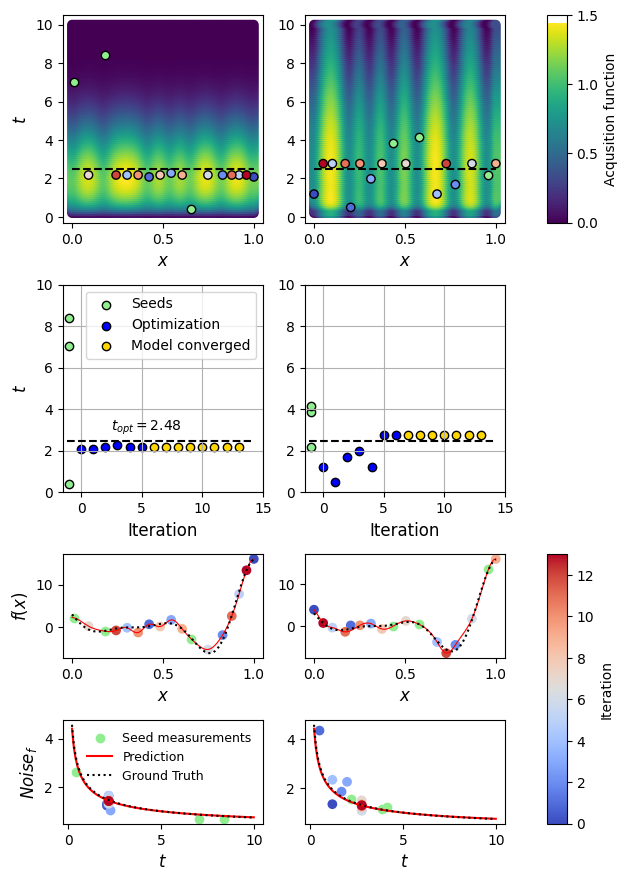

In [46]:
# Adjusted code to handle mismatched array sizes and generate the vertical plot
n_seeds = 3


# Create a figure with GridSpec for vertical arrangement
fig = plt.figure(figsize=(7.2, 10.5))
gs = fig.add_gridspec(4, 3, height_ratios=[1, 1, 0.5, 0.5], width_ratios=[1, 1, 0.1], left=0.15, right=0.85, hspace=0.4, wspace=0.3)

# First subplot (main scatter plot)
ax_main = fig.add_subplot(gs[0, 1])
scatter1 = ax_main.scatter(res_da['coord_all'][:,0], res_da['coord_all'][:,1], c=res_da['acq_list'][4])#, cmap='cividis')
ax_main.scatter(res_da['meas_coord'][-1][:n_seeds,0], res_da['meas_coord'][-1][:n_seeds,1], edgecolors='black', c='lightgreen')
scatter2 = ax_main.scatter(res_da['meas_coord'][-1][n_seeds:,0], res_da['meas_coord'][-1][n_seeds:,1], c=res_da['iter'][:-1], edgecolors='black', cmap='coolwarm')
ax_main.hlines(res_da['t_opt'], 0, 1, linestyle='dashed', color='black')
#ax_main.set_ylabel('$t$', fontsize=12)
ax_main.set_xlabel('$x$', fontsize=12)

# First subplot (main scatter plot) reward driven
ax_main = fig.add_subplot(gs[0, 0])
scatter1 = ax_main.scatter(res_pr['coord_all'][:,0], res_pr['coord_all'][:,1], c=res_pr['acq_list'][4])#, cmap='cividis')
ax_main.scatter(res_pr['meas_coord'][-1][:n_seeds,0], res_pr['meas_coord'][-1][:n_seeds,1], edgecolors='black', c='lightgreen')
scatter2 = ax_main.scatter(res_pr['meas_coord'][-1][n_seeds:,0], res_pr['meas_coord'][-1][n_seeds:,1], c=res_pr['iter'][:-1], edgecolors='black', cmap='coolwarm')
ax_main.hlines(res_pr['t_opt'], 0, 1, linestyle='dashed', color='black')
ax_main.set_ylabel('$t$', fontsize=12)
ax_main.set_xlabel('$x$', fontsize=12)

ax_bar1 = fig.add_subplot(gs[0, 2])
cbar2 = plt.colorbar(scatter1, orientation='vertical', cax = ax_bar1, fraction=0.046, pad=0.04)
cbar2.set_ticks([0,0.5,1,1.5])
cbar2.set_label('Acqusition function', fontsize=10)

ax_main2 = fig.add_subplot(gs[1, 1])
ax_main2.scatter(-np.ones(len(res_da['seeds'])), res_da['seeds'], color='lightgreen', ec='black', label='Seeds')
ax_main2.scatter(res_da['iter'][:-1][res_da['converge'][:-1]==0], res_da['exp_time'][res_da['converge'][:-1]==0], c='blue', ec='black', label='Optimization')
ax_main2.scatter(res_da['iter'][:-1][res_da['converge'][:-1]==1], res_da['exp_time'][res_da['converge'][:-1]==1], c='gold', ec='black', label='Model converged')
ax_main2.hlines(res_da['t_opt'], -1.2, res_da['iter'][-1], linestyle = '--', color = 'black')
#ax_main2.text(2.5, res_da['t_opt']+.5, s='$t_{opt}=$'+ '{}'.format(round(float(res_da['t_opt']), 2)))

ax_main2.set_ylim(0, 10)
#ax_main2.set_ylabel('$t$', fontsize=12)
#ax_main2.legend(fontsize=10)
ax_main2.grid()
ax_main2.set_xlim(-1.5,  res_da['iter'][-1]+1)
ax_main2.set_xlabel('Iteration', fontsize=12)

#reward-driven
ax_main2 = fig.add_subplot(gs[1, 0])
ax_main2.scatter(-np.ones(len(res_pr['seeds'])), res_pr['seeds'], color='lightgreen', ec='black', label='Seeds')
ax_main2.scatter(res_pr['iter'][:-1][res_pr['converge'][:-1]==0], res_pr['exp_time'][res_pr['converge'][:-1]==0], c='blue', ec='black', label='Optimization')
ax_main2.scatter(res_pr['iter'][:-1][res_pr['converge'][:-1]==1], res_pr['exp_time'][res_pr['converge'][:-1]==1], c='gold', ec='black', label='Model converged')
ax_main2.hlines(res_pr['t_opt'], -1.2, res_pr['iter'][-1], linestyle = '--', color = 'black')
ax_main2.text(2.5, res_pr['t_opt']+.5, s='$t_{opt}=$'+ '{}'.format(round(float(res_pr['t_opt']), 2)))

ax_main2.set_ylim(0, 10)
ax_main2.set_ylabel('$t$', fontsize=12)
ax_main2.legend(fontsize=10)
ax_main2.grid()
ax_main2.set_xlim(-1.5,  res_pr['iter'][-1]+1)
ax_main2.set_xlabel('Iteration', fontsize=12)


ax_bar = fig.add_subplot(gs[2:4, 2])
cbar1 = plt.colorbar(scatter2, cax=ax_bar, orientation='vertical')
cbar1.set_label('Iteration', fontsize=10)


ax_f = fig.add_subplot(gs[2,  1])
ax_f.plot(res_da['coord_all'][res_da['coord_all'][:,1]==res_da['exp_time'][-1]][:,0], res_da['y_pred'][-1][res_da['coord_all'][:,1]==res_da['exp_time'][-1]],
          c='red', lw=0.8, label='Prediction')
ax_f.scatter(res_da['meas_coord'][-1][:3,0], res_da['y_meas'][-1][:3], c='lightgreen', label='Seed measurements')
ax_f.scatter(res_da['meas_coord'][-1][3:,0], res_da['y_meas'][-1][3:], c=res_da['iter'][:-1], cmap='coolwarm')
ax_f.plot(np.unique(res_da['coord_all'][:,0]), res_da['y_gt'], ':', c='black', label='Ground Truth')
#ax_f.set_ylabel('$f(x)$', fontsize=12)
ax_f.set_xlabel('$x$', fontsize=12)

#reward-driven
ax_f = fig.add_subplot(gs[2,  0])
ax_f.plot(res_pr['coord_all'][res_pr['coord_all'][:,1]==res_pr['exp_time'][-1]][:,0], res_pr['y_pred'][-1][res_pr['coord_all'][:,1]==res_pr['exp_time'][-1]],
          c='red', lw=0.8, label='Prediction')
ax_f.scatter(res_pr['meas_coord'][-1][:3,0], res_pr['y_meas'][-1][:3], c='lightgreen', label='Seed measurements')
ax_f.scatter(res_pr['meas_coord'][-1][3:,0], res_pr['y_meas'][-1][3:], c=res_pr['iter'][:-1], cmap='coolwarm')
ax_f.plot(np.unique(res_pr['coord_all'][:,0]), res_pr['y_gt'], ':', c='black', label='Ground Truth')
ax_f.set_ylabel('$f(x)$', fontsize=12)
ax_f.set_xlabel('$x$', fontsize=12)

ax_n = fig.add_subplot(gs[3, 1])
t_all = res_da['coord_all'][res_da['coord_all'][:,0]==0][:,1]

ax_n.scatter(res_da['meas_coord'][-1][:3,1], res_da['y_noise'][-1][:3], c='lightgreen', label='Seed measurements')
ax_n.scatter(res_da['meas_coord'][-1][3:,1], res_da['y_noise'][-1][3:], c=res_da['iter'][:-1],  cmap='coolwarm')
ax_n.plot(t_all, variable_noise(t_all, res_da['a1'][-1], res_da['a0'][-1]), color='r', label='Prediction')
ax_n.plot(t_all, variable_noise(t_all, res_da['a1_gt'], res_da['a0_gt']), ':',color='black', label='Ground Truth')
#ax_n.legend(frameon=False, fontsize=9)
ax_n.set_xlabel('$t$', fontsize=12)
#ax_n.set_ylabel('$Noise_f$', fontsize=12)

#reward driven
ax_n = fig.add_subplot(gs[3, 0])
t_all = res_pr['coord_all'][res_pr['coord_all'][:,0]==0][:,1]

ax_n.scatter(res_pr['meas_coord'][-1][:3,1], res_pr['y_noise'][-1][:3], c='lightgreen', label='Seed measurements')
ax_n.scatter(res_pr['meas_coord'][-1][3:,1], res_pr['y_noise'][-1][3:], c=res_pr['iter'][:-1],  cmap='coolwarm')
ax_n.plot(t_all, variable_noise(t_all, res_pr['a1'][-1], res_pr['a0'][-1]), color='r', label='Prediction')
ax_n.plot(t_all, variable_noise(t_all, res_pr['a1_gt'], res_pr['a0_gt']), ':',color='black', label='Ground Truth')
ax_n.legend(frameon=False, fontsize=9)
ax_n.set_xlabel('$t$', fontsize=12)
ax_n.set_ylabel('$Noise_f$', fontsize=12)

fig.savefig('res_simulation.tif', dpi=300, bbox_inches='tight')

###Real experiment

In [28]:
!pip install igor2
!pip install SciFiReaders

  Using cached jedi-0.19.1-py2.py3-none-any.whl.metadata (22 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.2/84.2 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.4/102.4 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 32.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.9/69.9 kB 5.2 MB/s eta 0:00:00
Using cached jedi-0.19.1-py2.py3-none-any.whl (1.6 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 42.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 516.3/516.3 kB 25.0 MB/s eta 0:00:00


In [29]:
from SciFiReaders import IgorIBWReader

import numpy as np

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import Normalize, LogNorm

import h5py
from skimage import exposure, restoration

import cv2

You don't have gwyfile installed.     If you wish to open .gwy files, you will need to      install it (pip install gwyfile) before attempting.


In [30]:
#downloading the experimental results
!gdown https://drive.google.com/file/d/1HEcODaeK5Fe97GL0AET-XR0dJpmWhM91/view?usp=sharing --fuzzy -O 'exp_real2.h5'


Downloading...
From: https://drive.google.com/uc?id=1HEcODaeK5Fe97GL0AET-XR0dJpmWhM91
To: /content/exp_real2.h5
100% 5.06M/5.06M [00:00<00:00, 17.0MB/s]


In [31]:
#dowloading the overview scan
!gdown https://drive.google.com/file/d/1ainiFIwHxaQcwZ0t0fxdPqrLrh-DJ3V2/view?usp=sharing --fuzzy -O 'image.ibw'

Downloading...
From: https://drive.google.com/uc?id=1ainiFIwHxaQcwZ0t0fxdPqrLrh-DJ3V2
To: /content/image.ibw
100% 1.69M/1.69M [00:00<00:00, 25.5MB/s]


In [32]:
#download the real coordinates used in experiment
!gdown https://drive.google.com/file/d/1yNzraheJQU5JwYuEoa-s7xXAv3S30lWB/view?usp=sharing --fuzzy -O 'real_coord.npz'

Downloading...
From: https://drive.google.com/uc?id=1yNzraheJQU5JwYuEoa-s7xXAv3S30lWB
To: /content/real_coord.npz
100% 1.86k/1.86k [00:00<00:00, 7.48MB/s]


In [33]:
#@title auxiliary functions: saving

def convert_to_supported_dtype(arr):
    # Check if array has an object dtype
    if arr.dtype == np.dtype('O'):
        # Attempt conversion to a compatible type (if possible)
        try:
            return arr.astype(np.float64)  # Change to a compatible type (e.g., float)
        except ValueError:
            raise ValueError(f"Cannot convert array '{arr}' to a supported dtype.")
    return arr

def save_dict_to_hdf5(file_path, data_dict):
    def save_data(group, data):
        for key, value in data.items():
            if isinstance(value, dict):
                subgroup = group.create_group(key)
                save_data(subgroup, value)
            elif isinstance(value, np.ndarray):
                # Check and convert object dtype arrays if needed
                value = convert_to_supported_dtype(value)
                group.create_dataset(key, data=value)
            else:
                group.create_dataset(key, data=value)

    with h5py.File(file_path, 'w') as f:
        save_data(f, data_dict)

def load_hdf5_to_dict(file_path):
    def load_data(group):
        data = {}
        for key, item in group.items():
            if isinstance(item, h5py.Group):
                data[key] = load_data(item)
            else:
                data[key] = np.array(item)
        return data

    with h5py.File(file_path, 'r') as f:
        data_dict = load_data(f)

    return data_dict

In [34]:
#@title auxilary functions: parsing
def variable_noise(t, a, b,):
  return a/np.sqrt(t)+b

def parse_dict(data, n_seeds=3):
  # Initialize lists to store data
  iter_list = []
  a1_list = []
  a0_list = []
  conv_list = []
  y_pred_list = []
  t_iter_list = []
  y_prof_list = []
  acq_list = []
  meas_coord_list = []
  y_meas_list = []
  y_noise_list = []

  # Function to extract integer key from the dictionary
  def dict_key(d):
      return int(d.split('_')[1])

  # Sort keys based on the integer part after the underscore
  key_list = sorted(data0.keys(), key=dict_key)

  # Iterate through sorted keys and extract data
  for k in key_list:
      step = int(k.split('_')[-1])
      if step != -1:
          iter_list.append(step)
          a1_list.append(data0[k]['a0_a1'][1])
          a0_list.append(data0[k]['a0_a1'][0])
          conv_list.append(bool(data[k]['converge']))
          y_pred_list.append(data[k]['y_pred'])
          meas_coord_list.append(data[k]['coord'])

          t_current = data[k]['coord'][-1, 1]
          t_iter_list.append(t_current)

          # Filter predictions for the current time
          y_prof_list.append(data[k]['y_pred'][coord_all[:, 1] == t_current])

          acq_list.append(data[k]['acq'])
          y_meas_list.append(data[k]['y'])
          y_noise_list.append(data[k]['y_noise'])
      else:
          # Initialize ground truth parameters
          # a1_gt = data[k]['init_params']['a0_a1'][1]
          # a0_gt = data[k]['init_params']['a0_a1'][0]
          # exp_time_opt = data[k]['init_params']['t_opt']
          # y_gt = data[k]['init_params']['y_gt']
          coord_all = data[k]['init_params']['coord_all']

  # Convert accumulated lists to numpy arrays
  iter_array = np.array(iter_list)
  a1_array = np.array(a1_list)
  a0_array = np.array(a0_list)
  conv_array = np.array(conv_list)
  y_pred_array = np.array(y_pred_list)
  y_prof_array = np.array(y_prof_list)

  # Calculate RMSE for predictions
  #rmse_y = np.sqrt(np.mean((y_prof_array - y_gt) ** 2, axis=1))

  seeds = data[key_list[-1]]['coord'][:n_seeds, -1]
  exp_time = data[key_list[-1]]['coord'][n_seeds:, -1]

  return {'iter': iter_array,
          'a1': a1_array,
          'a0': a0_array,
          'converge': conv_array,
          'y_pred': y_pred_array,
          'y_prof': y_prof_array,
          #'rmse_y': rmse_y,
          'coord_all': coord_all,
          # 'y_gt': y_gt,
          # 't_opt': exp_time_opt,
          # 'a1_gt': a1_gt,
          # 'a0_gt': a0_gt,
          'meas_coord': meas_coord_list,
          'acq_list': acq_list,
          # 'exp_time': exp_time,
          'seeds': seeds,
          'y_meas': y_meas_list,
          'y_noise': y_noise_list,
          }

def correct_amp(amp, freq):
  freq_uint8 = cv2.normalize(freq, None, 0, 255, cv2.NORM_MINMAX).astype('uint8')
  _, otsu_thresholded = cv2.threshold(freq_uint8, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
  mask = cv2.bitwise_not(otsu_thresholded)//255

  matched = exposure.match_histograms(amp[mask !=0 ], amp[mask ==0])
  cor_amp = amp.copy()
  cor_amp[mask !=0 ] = matched

  return cor_amp

def real_to_pixel(real_coords, x_coords, y_coords):
    """
    Maps real-world coordinates to pixel coordinates based on the x_coords and y_coords arrays.

    Parameters:
    - real_coords: 2D NumPy array of shape (n, 2), where each row contains (x, y) real-world coordinates.
    - x_coords: 1D NumPy array of possible x-coordinates (real-world).
    - y_coords: 1D NumPy array of possible y-coordinates (real-world).

    Returns:
    - pixel_coords: 2D NumPy array of pixel coordinates corresponding to the real-world coordinates.
    """
    # Initialize array to store pixel coordinates
    pixel_coords = np.zeros_like(real_coords, dtype=int)

    # Find the closest x and y indices for each real coordinate
    pixel_coords[:, 0] = np.searchsorted(x_coords, real_coords[:, 0], side="left")
    pixel_coords[:, 1] = np.searchsorted(y_coords, real_coords[:, 1], side="left")

    return pixel_coords

def _calc_drive_params(_a1, _a2, _ph1, _ph2, _fc, _df):
        '''
        Calculate real Dart parameters from the observables.

        Input:
            _a1  - amplitude 1
            _a2  - amplitude 2
            _ph1 - phase 1
            _ph2 - phase 2
            _fc  - resonance frequency
            _df  - difference between freq 2 and freq 1
        Output:
            _a_drive  - drive amplitude
            _ph_drive - resonance phase
            _q        - resonanse quality factor
        '''

        epsilon = 1e-10  # a small adding for calculation stability
        _dph = _ph2 - _ph1
        _f1 = _fc - _df / 2
        _f2 = _fc + _df / 2

        _om = _f1 * _a1 / (_f2 * _a2)
        _fi = np.tan(_dph)

        _x1 = -(1 - np.sign(_fi) * np.sqrt(1 + np.square(_fi)) / _om) / (_fi + epsilon)
        _x2 = (1 - np.sign(_fi) * np.sqrt(1 + np.square(_fi)) * _om) / (_fi + epsilon)

        _q = np.sqrt(_f1 * _f2 * (_f2 * _x1 - _f1 * _x2) * (_f1 * _x1 - _f2 * _x2)) / (np.square(_f2) - np.square(_f1))
        _q[_q > 1000] = 1000
        _a_drive = _a1 * np.sqrt((_fc**2 - _f1**2)**2 +(_fc * _f1 / _q)**2) / np.square(_fc)
        _ph_drive = _ph1 - np.arctan(_fc * _f1 / (_q * (np.square(_fc) - np.square(_f1))))

        return _a_drive, _ph_drive, _q

In [35]:
#AE data
data0 = load_hdf5_to_dict('exp_real2.h5') #double_acq
dict_res = parse_dict(data0, n_seeds=3)

#real spacial coords
real_coord = np.load('real_coord.npz')['arr_0']

#scan data
reader = IgorIBWReader('image.ibw')
scans = reader.read()

keys = list(scans.keys())
freq = scans['Channel_005'].compute().T
amp = scans['Channel_001'].compute().T

amp, ph, q = _calc_drive_params(scans[keys[1]].compute().T, scans[keys[2]].compute().T, scans[keys[3]].compute().T, scans[keys[4]].compute().T, scans[keys[-1]].compute().T, 10)

cor_amp = correct_amp(amp, freq)

In [36]:
x_spacial, y_spacial = scans[keys[1]].x.values, scans[keys[1]].y.values
x_spacial = x_spacial - x_spacial[len(x_spacial)//2]
y_spacial = y_spacial - y_spacial[len(y_spacial)//2]

px_coord = real_to_pixel(real_coord, x_spacial, y_spacial)
real_profile = cor_amp[px_coord[:,1],px_coord[:,0]]

In [37]:
dist = ((real_coord[:, 0] - real_coord[0, 0])**2 + (real_coord[:, 1] - real_coord[0, 1])**2)**0.5*1e6
len(dist)

100

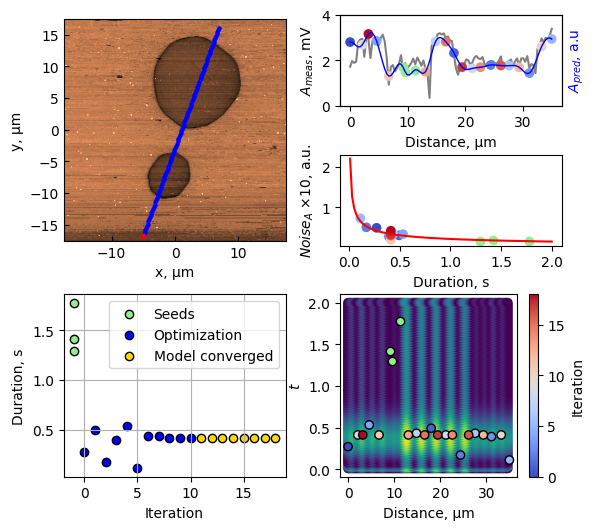

In [39]:
n_seeds = 3

# Create a figure with GridSpec for vertical arrangement
fig = plt.figure(figsize=(7.2, 6))
gs = fig.add_gridspec(3, 3, height_ratios=[0.5, 0.5, 1], width_ratios=[0.475, 0.475, 0.05], left=0.1, right=.9, hspace=0.4, wspace=.35,)# hspace=0.4, wspace=0.3)

ax_main = fig.add_subplot(gs[:2, 0])
ax_main.imshow(cor_amp, origin='lower', cmap='copper', extent=(x_spacial[0]*1e6, x_spacial[-1]*1e6, y_spacial[0]*1e6, y_spacial[-1]*1e6), vmax=0.5e-12)
ax_main.scatter(real_coord[:,0]*1e6, real_coord[:,1]*1e6, marker='o', s=5, color='b')
ax_main.scatter(real_coord[0,0]*1e6, real_coord[0,1]*1e6, marker='o', s=10, color='red')
ax_main.tick_params('both', direction='in')
ax_main.set_xlabel('x, µm')
ax_main.set_ylabel('y, µm')

ax1 = fig.add_subplot(gs[0, 1])

ax1.plot(dist, real_profile*1e13, color='gray')
ax1.plot()
ax1.set_ylim(0e-1, 40e-1)
ax1.set_ylabel(r'$A_{meas}$, mV', fontsize=10, color='black')

ax2 = ax1.twinx()
ax2.plot(dist, dict_res['y_prof'][-1], '-', lw=1, color='blue')
ax2.set_ylim(-10,25)
ax2.scatter(dist[dict_res['meas_coord'][-1][:n_seeds,0].astype(int)], dict_res['y_meas'][-1][:3], c='lightgreen', label='Seed measurements')
ax2.scatter(dist[dict_res['meas_coord'][-1][n_seeds:,0].astype(int)], dict_res['y_meas'][-1][3:], c=dict_res['iter'][:-1], cmap='coolwarm')
ax2.set_ylabel(r'$A_{pred}$, a.u', fontsize=10, color='blue')
ax2.set_yticks([])
ax1.set_xlabel('Distance, µm', fontsize=10)

ax_n = fig.add_subplot(gs[1,  1])

t_all = dict_res['coord_all'][dict_res['coord_all'][:,0]==0][:,1]

ax_n.scatter(dict_res['meas_coord'][-1][:3,1], dict_res['y_noise'][-1][:3]*10, c='lightgreen', label='Seed measurements')
ax_n.scatter(dict_res['meas_coord'][-1][3:,1], dict_res['y_noise'][-1][3:]*10, c=dict_res['iter'][:-1],  cmap='coolwarm')
ax_n.plot(t_all, variable_noise(t_all, dict_res['a1'][-1], dict_res['a0'][-1])*10, color='r', label='Prediction')
ax_n.set_xlabel('Duration, s', fontsize=10)
ax_n.set_ylabel(r'$Noise_A$ ×10, a.u.', fontsize=10)

ax_main1 = fig.add_subplot(gs[2, 1])
scatter1 = ax_main1.scatter(dict_res['coord_all'][:,0]/100*35, dict_res['coord_all'][:,1], c=dict_res['acq_list'][-7])#, cmap='cividis')
ax_main1.scatter(dist[dict_res['meas_coord'][-1][:n_seeds,0].astype(int)], dict_res['meas_coord'][-1][:n_seeds,1], edgecolors='black', c='lightgreen')
scatter2 = ax_main1.scatter(dist[dict_res['meas_coord'][-1][n_seeds:,0].astype(int)], dict_res['meas_coord'][-1][n_seeds:,1], c=dict_res['iter'][:-1], edgecolors='black', cmap='coolwarm')
ax_main1.set_ylabel('$t$', fontsize=10)
ax_main1.set_xlabel('Distance, µm', fontsize=10)

#reward-driven
ax_main2 = fig.add_subplot(gs[2, 0])
ax_main2.scatter(-np.ones(len(dict_res['seeds'])), dict_res['seeds'], color='lightgreen', ec='black', label='Seeds')
ax_main2.scatter(dict_res['iter'][:-1][dict_res['converge'][:-1]==0], dict_res['meas_coord'][-1][n_seeds:][dict_res['converge'][:-1]==0, 1],
                 c='blue', ec='black', label='Optimization')
ax_main2.scatter(dict_res['iter'][:-1][dict_res['converge'][:-1]==1], dict_res['meas_coord'][-1][n_seeds:][dict_res['converge'][:-1]==1, 1], c='gold', ec='black', label='Model converged')
ax_main2.grid()
ax_main2.set_xlabel('Iteration', fontsize=10)
ax_main2.set_ylabel('Duration, s', fontsize=10)
ax_main2.legend()


#ax_bar = fig.add_subplot(gs[2:4, 2])
cbar1 = plt.colorbar(scatter2, ax=ax_main1, orientation='vertical')
cbar1.set_label('Iteration', fontsize=10)

fig.savefig('res_real.jpg', dpi=300, bbox_inches='tight')

# for statistic visualization (raw data is available on the GitHub)

In [29]:
ue_pr = np.array([6,7,6,5,5,9,5,5,5,6])
ue_da = np.array([5,6,4,4,4,8,6,7,6,5])

ei_pr = np.array([3,5,2,10,6,5,5,7,6,9])
ei_da = np.array([6,7,3,5,8,8,5,4,5,5])

data = [ue_pr, ue_da, ei_pr, ei_da]
labels = ['UE, reward', 'UE, double acq.', 'EI, reward', 'EI, double acq.',]

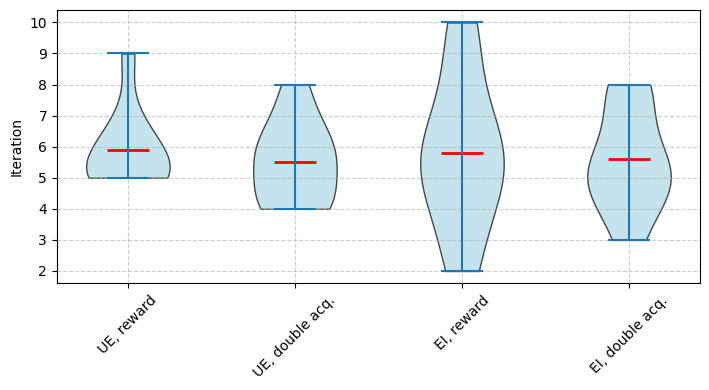

In [31]:
fig = plt.figure(figsize=(7.2, 4))

# Create the violin plot with additional features
parts = plt.violinplot(data, showmeans=True, showmedians=False, showextrema=True)

# Customize the colors
for pc in parts['bodies']:
    pc.set_facecolor('lightblue')
    pc.set_edgecolor('black')
    pc.set_alpha(0.7)

# Customize the median and mean lines
parts['cmeans'].set_color('red')  # Mean line in red
parts['cmeans'].set_linewidth(2)
#parts['cmedians'].set_color('black')  # Median line in black
#parts['cmedians'].set_linewidth(2)

# Adding grid for better readability
plt.grid(True, linestyle='--', alpha=0.6)

# Labels and title with rotation for x-labels
plt.ylabel('Iteration')
plt.xticks([1, 2, 3, 4], labels, rotation=45)

# Display the improved plot
plt.tight_layout()

fig.savefig('fig_s2.jpg', dpi=300, bbox_inches='tight')